## Библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Читаем с файла

In [4]:
prolongations = pd.read_csv("prolongations.csv", encoding = "UTF-8")
financial_data = pd.read_csv("financial_data.csv", encoding = "UTF-8")


In [5]:
prolongations.head()

,id,month,AM
0,42,ноябрь 2022,Васильев Артем Александрович
1,453,ноябрь 2022,Васильев Артем Александрович
2,548,ноябрь 2022,Михайлов Андрей Сергеевич
3,87,ноябрь 2022,Соколова Анастасия Викторовна
4,429,ноябрь 2022,Соколова Анастасия Викторовна


In [6]:
financial_data.head()

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
0,42,NaN,"36 220,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
1,657,первая часть оплаты,стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
2,657,вторая часть оплаты,стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
3,594,NaN,стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
4,665,NaN,"10 000,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович


## Преобразует названия месяцев в формат "year-month"

In [8]:
month_map = {
    "январь": "01", "февраль": "02", "март": "03", "апрель": "04",
    "май": "05", "июнь": "06", "июль": "07", "август": "08",
    "сентябрь": "09", "октябрь": "10", "ноябрь": "11", "декабрь": "12"
}

def format_month(m):
    parts = m.lower().split()
    return f"{parts[1]}-{month_map[parts[0]]}" if len(parts) == 2 else m

prolongations['month'] = prolongations['month'].apply(format_month)

## Преобразование значений в таблице financial_data

In [10]:
for col in financial_data.columns:
    if col not in ['id', 'Причина дубля', 'Account']:
        financial_data[col] = financial_data[col].astype(str).str.replace('\xa0', '', regex=False)
        financial_data[col] = financial_data[col].str.replace(' ', '').str.replace(',', '.').str.lower()
        financial_data[col] = financial_data[col].replace({'вноль': '0', 'стоп': np.nan, 'end': np.nan})
        financial_data[col] = pd.to_numeric(financial_data[col], errors='coerce')


## Переименование колонок месяцев в формат YYYY-MM

In [12]:
def convert_column_to_date(col):
    parts = col.lower().split()
    if len(parts) == 2 and parts[0] in month_map:
        return f"{parts[1]}-{month_map[parts[0]]}"
    return col

new_columns = {col: convert_column_to_date(col) for col in financial_data.columns}
financial_data.rename(columns=new_columns, inplace=True)

## Обновление списка месячных колонок

In [14]:
month_columns = [col for col in financial_data.columns if col not in ['id', 'Причина дубля', 'Account']]


## Группировка по id

In [16]:
financial_grouped = financial_data.groupby('id')[month_columns].sum().reset_index()

## Объединение с данными о пролонгации

In [18]:
df = prolongations.merge(financial_grouped, on='id', how='left')

## Удаление проектов со 'стоп' до окончания

In [20]:
def has_stop(row):
    stop_check_months = [col for col in month_columns if col <= row['month']]
    for col in stop_check_months:
        vals = financial_data.loc[financial_data['id'] == row['id'], col].astype(str).str.lower()
        if vals.isin(['стоп', 'end']).any():
            return True
    return False

df = df[~df.apply(has_stop, axis=1)]

## Расчет коэффициентов пролонгации

In [22]:
results = []

for month in pd.date_range('2023-01-01', '2023-12-01', freq='MS'):
    m_str = month.strftime('%Y-%m')
    prev_m = (month - pd.DateOffset(months=1)).strftime('%Y-%m')
    prev2_m = (month - pd.DateOffset(months=2)).strftime('%Y-%m')

    for am in df['AM'].unique():
        df_am = df[df['AM'] == am]

        sub1 = df_am[df_am['month'] == prev_m]
        if prev_m in sub1.columns and m_str in sub1.columns:
            numer1 = sub1[m_str].fillna(0).sum()
            denom1 = sub1[prev_m].fillna(0).sum()
            coeff1 = round(numer1 / denom1 * 100, 1) if denom1 else 0
        else:
            coeff1 = 0

        sub2 = df_am[df_am['month'] == prev2_m]
        if prev_m in sub2.columns and prev2_m in sub2.columns and m_str in sub2.columns:
            no_first = sub2[prev_m].fillna(0) == 0
            numer2 = sub2.loc[no_first, m_str].fillna(0).sum()
            denom2 = sub2.loc[no_first, prev2_m].fillna(0).sum()
            coeff2 = round(numer2 / denom2 * 100, 1) if denom2 else 0
        else:
            coeff2 = 0

        results.append({'Month': m_str, 'AM': am, 'FirstCoeff': coeff1, 'SecondCoeff': coeff2})

## Результат по месяцам

In [24]:
result_df = pd.DataFrame(results)

## Расчёт среднегодовых коэффициентов по каждому менеджеру и отделу

In [26]:
am_summary = result_df.groupby('AM')[['FirstCoeff', 'SecondCoeff']].mean().reset_index()
am_summary['FirstCoeff'] = am_summary['FirstCoeff'].round(1)
am_summary['SecondCoeff'] = am_summary['SecondCoeff'].round(1)
am_summary.rename(columns={'FirstCoeff': '1-й месяц (%)', 'SecondCoeff': '2-й месяц (%)'}, inplace=True)

overall_summary = pd.DataFrame({
    'AM': ['Среднее по менеджерам:'],
    '1-й месяц (%)': [am_summary['1-й месяц (%)'].mean().round(1)],
    '2-й месяц (%)': [am_summary['2-й месяц (%)'].mean().round(1)]
})

year_summary = pd.concat([am_summary, overall_summary], ignore_index=True)

## Печать итогов

In [28]:
result_df.head()

,Month,AM,FirstCoeff,SecondCoeff
0,2023-01,Васильев Артем Александрович,55.6,0.0
1,2023-01,Михайлов Андрей Сергеевич,68.8,0.0
2,2023-01,Соколова Анастасия Викторовна,42.7,67.9
3,2023-01,Иванова Мария Сергеевна,27.0,0.0
4,2023-01,Попова Екатерина Николаевна,44.1,0.0


## Печать годовых итогов

In [30]:
year_summary

,AM,1-й месяц (%),2-й месяц (%)
0,Васильев Артем Александрович,55.4,13.5
1,Иванова Мария Сергеевна,33.4,0.0
2,Кузнецов Михаил Иванович,34.8,0.0
3,Михайлов Андрей Сергеевич,66.3,0.0
4,Петрова Анна Дмитриевна,9.3,0.0
5,Попова Екатерина Николаевна,38.3,12.6
6,Смирнова Ольга Владимировна,45.6,30.2
7,Соколова Анастасия Викторовна,57.8,7.5
8,Федорова Марина Васильевна,0.0,0.0
9,без А/М,0.0,0.0


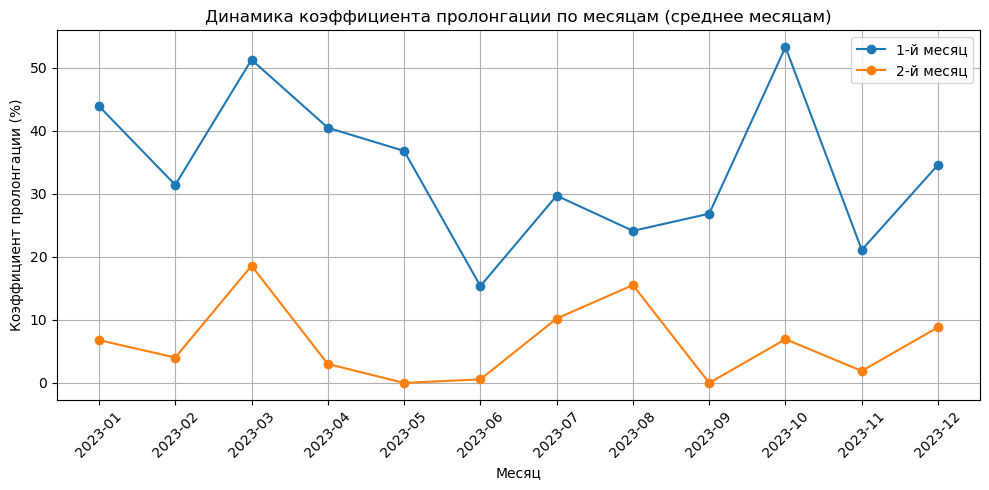

In [107]:
# Группировка по месяцу и усреднение по всем AM
monthly_avg = result_df.groupby('Month')[['FirstCoeff', 'SecondCoeff']].mean().reset_index()

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg['Month'], monthly_avg['FirstCoeff'], marker='o', label='1-й месяц')
plt.plot(monthly_avg['Month'], monthly_avg['SecondCoeff'], marker='o', label='2-й месяц')
plt.xticks(rotation=45)
plt.title('Динамика коэффициента пролонгации по месяцам (среднее по месяцам)')
plt.xlabel('Месяц')
plt.ylabel('Коэффициент пролонгации (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


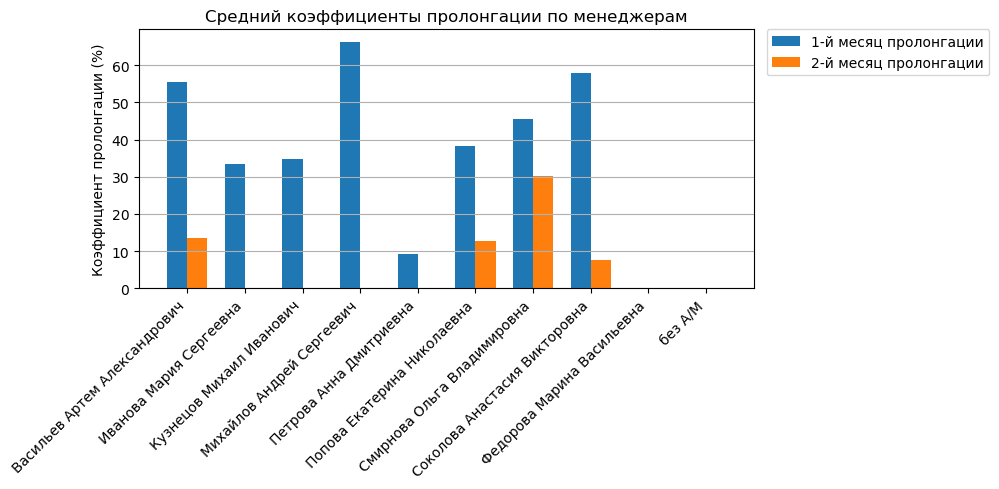

In [105]:
# Группировка по AM: среднее значение коэффициентов
manager_avg = result_df.groupby('AM')[['FirstCoeff', 'SecondCoeff']].mean().reset_index()

# Построение графика
plt.figure(figsize=(10, 5))
bar_width = 0.35
x = range(len(manager_avg))

plt.bar(x, manager_avg['FirstCoeff'], width=bar_width, label='1-й месяц пролонгации')
plt.bar([i + bar_width for i in x], manager_avg['SecondCoeff'], width=bar_width, label='2-й месяц пролонгации')

plt.xticks([i + bar_width / 2 for i in x], manager_avg['AM'], rotation=45, ha='right')
plt.ylabel('Коэффициент пролонгации (%)')
plt.title('Средний коэффициенты пролонгации по менеджерам')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## Сохраняем таблицы в Excel

In [103]:

with pd.ExcelWriter("Пролонгация_отчет.xlsx", engine='xlsxwriter') as writer:
    result_df.to_excel(writer, sheet_name='Коэффициенты по месяцам', index=False)
    year_summary.to_excel(writer, sheet_name='Средние показатели сотрудникам за год', index=False)
    monthly_avg = result_df.groupby('Month')[['FirstCoeff', 'SecondCoeff']].mean().reset_index()
    monthly_avg.to_excel(writer, sheet_name='Динамика за год', index=False)

print("Данные успешно сохранены в файл Пролонгация_отчет.xlsx")

Данные успешно сохранены в файл Пролонгация_отчет.xlsx
